# 마케팅 Multi-Agent 시스템 테스트

각 Agent의 출력을 단계별로 테스트합니다.

## 1. 환경 설정

In [1]:
import sys
import os
from datetime import datetime, timedelta
from pprint import pprint
import json

# 프로젝트 루트 경로 추가
if os.path.abspath('.') not in sys.path:
    sys.path.insert(0, os.path.abspath('.'))

# 환경 변수 로드
from dotenv import load_dotenv
load_dotenv()

print("✅ 환경 설정 완료")

✅ 환경 설정 완료


## 2. Import

In [2]:
from agents import (
    marketing_graph,
    store_resolver_node,
    strategy_supervisor_node,
    context_agent_node,
    situation_agent_node,
    resource_agent_node,
    merge_supervisor_node,
    evaluation_agent_node
)

print("✅ Agent 모듈 import 완료")

2025-10-14 10:29:34.137 | WARNING  | tools.rag_tool:<module>:13 - Pinecone 또는 sentence_transformers 미설치
2025-10-14 10:29:34.698 | WARNING  | tools.store_search_tool:<module>:18 - FastMCP not available, using mock data


✅ Agent 모듈 import 완료


## 3. 테스트 State 생성

In [3]:
def create_test_state(user_query: str, budget_krw: int = 50000, channels: list = None):
    """테스트용 초기 상태 생성"""
    if channels is None:
        channels = ["kakao", "instagram"]
    
    return {
        "user_query": user_query,
        "intent": "strategy",
        "constraints": {
            "store_id": "S123",
            "start_date": (datetime.now() - timedelta(days=30)).strftime("%Y-%m-%d"),
            "end_date": datetime.now().strftime("%Y-%m-%d"),
            "budget_krw": budget_krw,
            "budget_tier": "low" if budget_krw < 100000 else "med",
            "preferred_channels": channels
        },
        "context_json": None,
        "situation_json": None,
        "resource_json": None,
        "strategy_cards": [],
        "eval_report": None,
        "batch_eval_result": None,
        "logs": []
    }

# 테스트 케이스
test_cases = [
    "평일 점심 매출을 늘리고 싶어. 예산 5만원, 카카오로.",
    "이번 주 비 온다는데 매출 영향 있을까?",
    "주말 고객을 평일로 분산시키고 싶어."
]

print("✅ 테스트 케이스 준비 완료")
print(f"테스트 케이스 수: {len(test_cases)}")

✅ 테스트 케이스 준비 완료
테스트 케이스 수: 3


## 4. 개별 Agent 테스트

### 4.1 Strategy Supervisor (의도 분석)

In [4]:
print("="*60)
print("Strategy Supervisor 테스트")
print("="*60)

test_state = create_test_state(test_cases[0])
result = strategy_supervisor_node(test_state)

print(f"\n질문: {test_state['user_query']}")
print(f"\n분석된 Intent: {result.get('intent')}")
print(f"\n로그:")
for log in result.get('logs', []):
    print(f"  {log}")

2025-10-14 10:04:40.666 | INFO     | agents.strategy_supervisor:strategy_supervisor_node:17 - Strategy Supervisor: 시작
2025-10-14 10:04:40.667 | INFO     | agents.strategy_supervisor:strategy_supervisor_node:26 - Intent detected: strategy


Strategy Supervisor 테스트

질문: 평일 점심 매출을 늘리고 싶어. 예산 5만원, 카카오로.

분석된 Intent: strategy

로그:
  [2025-10-14 10:04:40.669140] strategy_supervisor: 의도 분석 시작
  [2025-10-14 10:04:40.669159] intent: strategy


### 4.2 Context Agent (컨텍스트 생성)

In [5]:
print("="*60)
print("Context Agent 테스트")
print("="*60)

test_state = create_test_state(test_cases[0])
result = context_agent_node(test_state)

context = result.get('context_json', {})

print(f"\n📊 KPI:")
kpi = context.get('metrics', {}).get('kpi', {})
print(f"  매출: {kpi.get('sales_sum', 0):,}원")
print(f"  방문: {kpi.get('visits_sum', 0):,}회")
print(f"  객단가: {kpi.get('aov', 0):,}원")
print(f"  재방문율: {kpi.get('repeat_rate', 0):.1%}")

print(f"\n📈 파생 지표:")
derived = context.get('metrics', {}).get('derived', {})
print(f"  경쟁강도: {derived.get('comp_intensity', 0):.2f}")
print(f"  런치비중: {derived.get('lunch_share', 0):.1%}")
print(f"  주말편중: {derived.get('weekend_share', 0):.1%}")

print(f"\n⚠️ 위험 평가:")
risk = context.get('risk', {})
print(f"  위험점수: {risk.get('score', 0):.2f}")
print(f"  유형: {risk.get('typology', 'N/A')}")
print(f"  요인: {', '.join(risk.get('reasons', []))}")

2025-10-14 10:04:40.680 | INFO     | agents.context_agent:context_agent_node:18 - Context Agent: 시작
2025-10-14 10:04:40.682 | INFO     | agents.context_agent:context_agent_node:23 - Context Agent: 완료


Context Agent 테스트

📊 KPI:
  매출: 12,500,000.0원
  방문: 3,200회
  객단가: 39,000.0원
  재방문율: 27.0%

📈 파생 지표:
  경쟁강도: 0.74
  런치비중: 18.0%
  주말편중: 62.0%

⚠️ 위험 평가:
  위험점수: 0.67
  유형: over_comp
  요인: comp_intensity↑, same_industry_sales_ratio=0.82


### 4.3 Situation Agent (상황 인식)

In [6]:
print("="*60)
print("Situation Agent 테스트")
print("="*60)

# 날씨 관련 질문으로 테스트
test_state = create_test_state(test_cases[1])
result = situation_agent_node(test_state)

situation = result.get('situation_json', {})

print(f"\n질문: {test_state['user_query']}")
print(f"\n유효 신호: {situation.get('has_valid_signal')}")
print(f"요약: {situation.get('summary')}")

signals = situation.get('signals', [])
if signals:
    print(f"\n신호 상세 ({len(signals)}개):")
    for idx, signal in enumerate(signals, 1):
        print(f"\n  [{idx}] {signal.get('signal_type').upper()}")
        print(f"      설명: {signal.get('description')}")
        print(f"      관련성: {signal.get('relevance', 0):.2f}")
        print(f"      이유: {signal.get('reason')}")

2025-10-14 00:59:31.543 | INFO     | agents.situation_agent:situation_agent_node:18 - Situation Agent: 시작
2025-10-14 00:59:31.545 | INFO     | agents.situation_agent:situation_agent_node:36 - Situation Agent: 완료 (신호: 2개)


Situation Agent 테스트

질문: 이번 주 비 온다는데 매출 영향 있을까?

유효 신호: True
요약: 우천(POP≥60%) + 대규모 행사 → 유동 흐름 변화 예상

신호 상세 (2개):

  [1] WEATHER
      설명: 강수확률 70%, 예보 강수량 18.0mm
      관련성: 0.82
      이유: POP≥60% 충족

  [2] EVENT
      설명: 한강 야시장 (예상 8천명)
      관련성: 0.75
      이유: 도보 15분 이내 대규모 행사


### 4.4 Resource Agent (리소스 매칭)

In [7]:
print("="*60)
print("Resource Agent 테스트")
print("="*60)

test_state = create_test_state(test_cases[0])
result = resource_agent_node(test_state)

resource = result.get('resource_json', {})
card = resource.get('resource_card', {})
package = card.get('package', {})

print(f"\n제목: {card.get('title')}")
print(f"요약: {card.get('summary')}")

print(f"\n패키지 정보:")
print(f"  ID: {package.get('id')}")
print(f"  채널: {package.get('channel')}")
budget = package.get('budget', {})
print(f"  예산: {budget.get('cap', 0):,}{budget.get('unit', 'KRW')} ({budget.get('tier', 'N/A')})")
print(f"  적합도: {package.get('fit_score', 0):.2f}")

print(f"\n실행 체크리스트:")
execution = card.get('execution', {})
for item in execution.get('checklist', []):
    print(f"  ☐ {item.get('step')} (담당: {item.get('owner')}, 소요: {item.get('eta_min')}분)")

print(f"\n예상 비용:")
costs = execution.get('estimated_costs', {})
print(f"  매체비: {costs.get('media_spend', 0):,}원")
print(f"  제작비: {costs.get('production_spend', 0):,}원")

2025-10-14 00:59:32.338 | INFO     | agents.resource_agent:resource_agent_node:18 - Resource Agent: 시작
2025-10-14 00:59:32.340 | INFO     | agents.resource_agent:resource_agent_node:22 - Resource Agent: 완료


Resource Agent 테스트

제목: Kakao 저예산 패키지
요약: 예산 50,000원으로 실행 가능한 kakao 캠페인

패키지 정보:
  ID: CAT-KAKAO-LOW-01
  채널: kakao
  예산: 50,000KRW (low)
  적합도: 0.86

실행 체크리스트:
  ☐ 카톡 채널 쿠폰 발급 (담당: owner, 소요: 15분)
  ☐ 알림톡 템플릿 작성 (담당: owner, 소요: 20분)
  ☐ 타겟 세그먼트 설정 (담당: owner, 소요: 10분)

예상 비용:
  매체비: 30,000원
  제작비: 0원


### 4.5 Merge Supervisor (전략 생성)

In [8]:
print("="*60)
print("Merge Supervisor 테스트")
print("="*60)

# 먼저 데이터 수집
test_state = create_test_state(test_cases[0])

# Context 생성
ctx_result = context_agent_node(test_state)
test_state['context_json'] = ctx_result['context_json']

# Situation 생성
sit_result = situation_agent_node(test_state)
test_state['situation_json'] = sit_result['situation_json']

# Resource 생성
res_result = resource_agent_node(test_state)
test_state['resource_json'] = res_result['resource_json']

# 전략 생성
result = merge_supervisor_node(test_state)

cards = result.get('strategy_cards', [])
print(f"\n생성된 전략 카드: {len(cards)}개\n")

for idx, card in enumerate(cards, 1):
    print(f"[카드 {idx}]")
    print(f"제목: {card.get('title')}")
    print(f"\n가설: {card.get('hypothesis')}")
    
    print(f"\n근거:")
    for why in card.get('why', []):
        print(f"  • {why}")
    
    print(f"\n타겟: {card.get('target_segment')}")
    print(f"채널: {', '.join(card.get('channel_hints', []))}")
    print(f"제안: {card.get('offer')}")
    
    timeline = card.get('timeline', {})
    print(f"\n기간: {timeline.get('start')} ~ {timeline.get('end')}")
    
    budget = card.get('budget', {})
    print(f"예산: {budget.get('cap', 0):,}{budget.get('unit', 'KRW')}")
    
    kpi = card.get('kpi_targets', {}).get('primary', {})
    print(f"목표: {kpi.get('metric')} {kpi.get('target')}")
    
    print(f"\n위험:")
    for risk in card.get('risks', []):
        print(f"  ⚠️ {risk}")

2025-10-14 00:59:33.214 | INFO     | agents.context_agent:context_agent_node:18 - Context Agent: 시작
2025-10-14 00:59:33.216 | INFO     | agents.context_agent:context_agent_node:23 - Context Agent: 완료
2025-10-14 00:59:33.216 | INFO     | agents.situation_agent:situation_agent_node:18 - Situation Agent: 시작
2025-10-14 00:59:33.217 | INFO     | agents.situation_agent:situation_agent_node:22 - 상황 분석 불필요
2025-10-14 00:59:33.218 | INFO     | agents.resource_agent:resource_agent_node:18 - Resource Agent: 시작
2025-10-14 00:59:33.219 | INFO     | agents.resource_agent:resource_agent_node:22 - Resource Agent: 완료
2025-10-14 00:59:33.220 | INFO     | agents.strategy_supervisor:merge_supervisor_node:41 - Merge Supervisor: 데이터 통합 시작
2025-10-14 00:59:33.220 | INFO     | agents.strategy_supervisor:merge_supervisor_node:62 - 전략 카드 생성 완료: 1개


Merge Supervisor 테스트

생성된 전략 카드: 1개

[카드 1]
제목: 평일 런치 타겟 번들 프로모션

가설: 런치 비중이 낮고 주말에 편중된 매출 구조를 평일로 분산하여 전체 매출 증대

근거:
  • 주말 편중: 62%
  • 런치 비중: 18%

타겟: 직장인, 20-40대
채널: kakao, instagram
제안: 11-14시 세트 메뉴 3종, 15% 할인

기간: 2025-10-14 ~ 2025-11-30
예산: 50,000KRW
목표: trans +8%/2w

위험:
  ⚠️ 직원 대응 역량 부족 시 고객 불만 발생 가능
  ⚠️ 재료 수급 이슈 발생 시 프로모션 중단 리스크


### 4.6 Evaluation Agent (평가)

In [9]:
print("="*60)
print("Evaluation Agent 테스트")
print("="*60)

# 이전 단계에서 생성된 전략 카드가 있는 상태 사용
result = evaluation_agent_node(test_state)

eval_report = result.get('eval_report', {})

severity_emoji = {
    'low': '🟢',
    'medium': '🟡',
    'high': '🔴'
}

print(f"\n요약: {eval_report.get('summary')}")
print(f"심각도: {severity_emoji.get(eval_report.get('severity'), '⚪')} {eval_report.get('severity')}")

checks = eval_report.get('checks', [])
print(f"\n검증 결과:")
for check in checks:
    card_idx = check.get('card_idx')
    print(f"\n  [카드 {card_idx + 1}]")
    
    constraint_fit = '✅' if check.get('constraint_fit') else '❌'
    evidence_match = '✅' if check.get('evidence_match') else '❌'
    
    print(f"    제약 부합: {constraint_fit}")
    print(f"    근거 매칭: {evidence_match}")
    
    risk_notes = check.get('risk_notes', [])
    if risk_notes:
        print(f"    위험 노트:")
        for note in risk_notes:
            print(f"      • {note}")
    
    fix = check.get('fix_suggestion')
    if fix:
        print(f"    💡 수정 제안: {fix}")

print(f"\n권장 액션:")
for action in eval_report.get('recommended_actions', []):
    print(f"  • {action.get('action')}: {action.get('impact')}")

2025-10-14 00:59:34.669 | INFO     | agents.evaluation_agent:evaluation_agent_node:19 - Evaluation Agent: 시작
2025-10-14 00:59:34.671 | WARNING  | agents.evaluation_agent:evaluation_agent_node:24 - 평가할 전략 카드 없음


Evaluation Agent 테스트

요약: None
심각도: ⚪ None

검증 결과:

권장 액션:


## 5. 전체 그래프 실행 테스트

In [10]:
def test_full_graph(question: str, budget: int = 50000, channels: list = None):
    """전체 그래프 실행 테스트"""
    print("="*60)
    print(f"질문: {question}")
    print("="*60)
    
    initial_state = create_test_state(question, budget, channels)
    
    print("\n🚀 그래프 실행 중...\n")
    final_state = marketing_graph.invoke(initial_state)
    
    # 결과 출력
    print("\n" + "="*60)
    print("최종 결과")
    print("="*60)
    
    print(f"\n🎯 Intent: {final_state.get('intent')}")
    
    # 전략 카드
    cards = final_state.get('strategy_cards', [])
    print(f"\n📊 생성된 전략: {len(cards)}개")
    for idx, card in enumerate(cards, 1):
        print(f"\n  [{idx}] {card.get('title')}")
        print(f"      타겟: {card.get('target_segment')}")
        print(f"      제안: {card.get('offer')}")
    
    # 평가
    eval_report = final_state.get('eval_report', {})
    if eval_report:
        print(f"\n✅ 평가: {eval_report.get('summary')}")
        print(f"   심각도: {eval_report.get('severity')}")
    
    # 로그 (마지막 5개)
    logs = final_state.get('logs', [])
    print(f"\n📝 실행 로그 (마지막 5개):")
    for log in logs[-5:]:
        print(f"   {log}")
    
    return final_state

In [11]:
# 테스트 케이스 1
result1 = test_full_graph(
    "평일 점심 매출을 늘리고 싶어. 예산 5만원, 카카오로.",
    budget=50000,
    channels=["kakao"]
)

2025-10-14 00:59:37.132 | INFO     | agents.strategy_supervisor:strategy_supervisor_node:17 - Strategy Supervisor: 시작
2025-10-14 00:59:37.132 | INFO     | agents.strategy_supervisor:strategy_supervisor_node:26 - Intent detected: strategy
2025-10-14 00:59:37.134 | INFO     | agents.context_agent:context_agent_node:18 - Context Agent: 시작
2025-10-14 00:59:37.136 | INFO     | agents.context_agent:context_agent_node:23 - Context Agent: 완료
2025-10-14 00:59:37.136 | INFO     | agents.resource_agent:resource_agent_node:18 - Resource Agent: 시작
2025-10-14 00:59:37.137 | INFO     | agents.situation_agent:situation_agent_node:18 - Situation Agent: 시작
2025-10-14 00:59:37.140 | INFO     | agents.resource_agent:resource_agent_node:22 - Resource Agent: 완료
2025-10-14 00:59:37.141 | INFO     | agents.situation_agent:situation_agent_node:22 - 상황 분석 불필요
2025-10-14 00:59:37.144 | INFO     | agents.strategy_supervisor:merge_supervisor_node:41 - Merge Supervisor: 데이터 통합 시작
2025-10-14 00:59:37.145 | INFO     

질문: 평일 점심 매출을 늘리고 싶어. 예산 5만원, 카카오로.

🚀 그래프 실행 중...


최종 결과

🎯 Intent: strategy

📊 생성된 전략: 1개

  [1] 평일 런치 타겟 번들 프로모션
      타겟: 직장인, 20-40대
      제안: 11-14시 세트 메뉴 3종, 15% 할인

✅ 평가: 카드 1건 중 1건 적합, 0건 수정 권고
   심각도: low

📝 실행 로그 (마지막 5개):
   [2025-10-14 00:59:37.142251] resource_agent: 리소스 매칭 완료
   [2025-10-14 00:59:37.143723] situation_agent: 스킵 (관련 키워드 없음)
   [2025-10-14 00:59:37.145212] merge_supervisor: 3개 에이전트 결과 통합
   [2025-10-14 00:59:37.145355] 전략 카드 생성 완료: 평일 런치 타겟 번들 프로모션
   [2025-10-14 00:59:37.149021] evaluation_agent: 평가 완료 (심각도: low)


In [12]:
# 테스트 케이스 2 (상황 인식 포함)
result2 = test_full_graph(
    "이번 주 비 온다는데 매출 영향 있을까?",
    budget=100000,
    channels=["instagram", "kakao"]
)

2025-10-14 00:59:37.437 | INFO     | agents.strategy_supervisor:strategy_supervisor_node:17 - Strategy Supervisor: 시작
2025-10-14 00:59:37.438 | INFO     | agents.strategy_supervisor:strategy_supervisor_node:26 - Intent detected: strategy
2025-10-14 00:59:37.441 | INFO     | agents.context_agent:context_agent_node:18 - Context Agent: 시작
2025-10-14 00:59:37.442 | INFO     | agents.resource_agent:resource_agent_node:18 - Resource Agent: 시작
2025-10-14 00:59:37.443 | INFO     | agents.context_agent:context_agent_node:23 - Context Agent: 완료
2025-10-14 00:59:37.443 | INFO     | agents.situation_agent:situation_agent_node:18 - Situation Agent: 시작
2025-10-14 00:59:37.445 | INFO     | agents.resource_agent:resource_agent_node:22 - Resource Agent: 완료
2025-10-14 00:59:37.448 | INFO     | agents.situation_agent:situation_agent_node:36 - Situation Agent: 완료 (신호: 2개)
2025-10-14 00:59:37.451 | INFO     | agents.strategy_supervisor:merge_supervisor_node:41 - Merge Supervisor: 데이터 통합 시작


질문: 이번 주 비 온다는데 매출 영향 있을까?

🚀 그래프 실행 중...



ValidationError: 2 validation errors for InputsUsed
situation_signal_ids.0
  Input should be a valid string [type=string_type, input_value={'signal_id': 'WX-2025101...on': 'POP≥60% 충족'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
situation_signal_ids.1
  Input should be a valid string [type=string_type, input_value={'signal_id': 'EV-2025101...내 대규모 행사'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type

In [13]:
# 테스트 케이스 3
result3 = test_full_graph(
    "주말 고객을 평일로 분산시키고 싶어.",
    budget=200000,
    channels=["instagram", "facebook"]
)

2025-10-14 00:59:38.057 | INFO     | agents.strategy_supervisor:strategy_supervisor_node:17 - Strategy Supervisor: 시작
2025-10-14 00:59:38.058 | INFO     | agents.strategy_supervisor:strategy_supervisor_node:26 - Intent detected: strategy
2025-10-14 00:59:38.060 | INFO     | agents.context_agent:context_agent_node:18 - Context Agent: 시작
2025-10-14 00:59:38.062 | INFO     | agents.context_agent:context_agent_node:23 - Context Agent: 완료
2025-10-14 00:59:38.063 | INFO     | agents.resource_agent:resource_agent_node:18 - Resource Agent: 시작
2025-10-14 00:59:38.065 | INFO     | agents.situation_agent:situation_agent_node:18 - Situation Agent: 시작
2025-10-14 00:59:38.066 | INFO     | agents.resource_agent:resource_agent_node:22 - Resource Agent: 완료
2025-10-14 00:59:38.066 | INFO     | agents.situation_agent:situation_agent_node:22 - 상황 분석 불필요
2025-10-14 00:59:38.069 | INFO     | agents.strategy_supervisor:merge_supervisor_node:41 - Merge Supervisor: 데이터 통합 시작
2025-10-14 00:59:38.070 | INFO     

질문: 주말 고객을 평일로 분산시키고 싶어.

🚀 그래프 실행 중...


최종 결과

🎯 Intent: strategy

📊 생성된 전략: 1개

  [1] 평일 런치 타겟 번들 프로모션
      타겟: 직장인, 20-40대
      제안: 11-14시 세트 메뉴 3종, 15% 할인

✅ 평가: 카드 1건 중 1건 적합, 0건 수정 권고
   심각도: low

📝 실행 로그 (마지막 5개):
   [2025-10-14 00:59:38.067677] resource_agent: 리소스 매칭 완료
   [2025-10-14 00:59:38.068822] situation_agent: 스킵 (관련 키워드 없음)
   [2025-10-14 00:59:38.070165] merge_supervisor: 3개 에이전트 결과 통합
   [2025-10-14 00:59:38.070305] 전략 카드 생성 완료: 평일 런치 타겟 번들 프로모션
   [2025-10-14 00:59:38.074219] evaluation_agent: 평가 완료 (심각도: low)


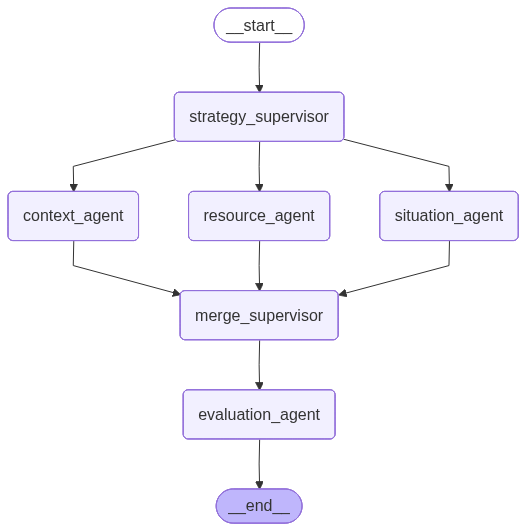

In [18]:
from typing import Literal, TypedDict, Annotated
from langgraph.graph import StateGraph, END
import operator

from agents.strategy_supervisor import strategy_supervisor_node, merge_supervisor_node
from agents.context_agent import context_agent_node
from agents.situation_agent import situation_agent_node
from agents.resource_agent import resource_agent_node
from agents.evaluation_agent import evaluation_agent_node


class AgentState(TypedDict):
    """중앙 상태 관리 - TypedDict 사용"""
    user_query: str
    intent: str
    constraints: dict
    
    # 데이터 수집 결과
    context_json: dict | None
    situation_json: dict | None
    resource_json: dict | None
    
    # 전략 생성 결과
    strategy_cards: list[dict]
    
    # 평가 결과
    eval_report: dict | None
    batch_eval_result: dict | None
    
    # 로그 - 병렬 처리를 위해 Annotated 사용
    logs: Annotated[list[str], operator.add]



"""
LangGraph 조립

흐름:
1. strategy_supervisor (엔트리)
2. context_agent, situation_agent, resource_agent (병렬)
3. merge_supervisor (데이터 통합 및 전략 생성)
4. evaluation_agent (전략 평가)
5. END
"""
builder = StateGraph(AgentState)

# 노드 등록
builder.add_node("strategy_supervisor", strategy_supervisor_node)
builder.add_node("context_agent", context_agent_node)
builder.add_node("situation_agent", situation_agent_node)
builder.add_node("resource_agent", resource_agent_node)
builder.add_node("merge_supervisor", merge_supervisor_node)
builder.add_node("evaluation_agent", evaluation_agent_node)

# 엔트리 포인트
builder.set_entry_point("strategy_supervisor")

# 병렬 실행: 3개 에이전트 동시 실행
builder.add_edge("strategy_supervisor", "context_agent")
builder.add_edge("strategy_supervisor", "situation_agent")
builder.add_edge("strategy_supervisor", "resource_agent")

# 병렬 완료 후 merge로 수렴
builder.add_edge("context_agent", "merge_supervisor")
builder.add_edge("situation_agent", "merge_supervisor")
builder.add_edge("resource_agent", "merge_supervisor")

# 평가 및 종료
builder.add_edge("merge_supervisor", "evaluation_agent")
builder.add_edge("evaluation_agent", END)

builder.compile()



## 6. 상세 결과 분석

In [14]:
def analyze_result(state):
    """결과 상세 분석"""
    print("="*60)
    print("상세 분석")
    print("="*60)
    
    # Context 분석
    context = state.get('context_json', {})
    if context:
        print("\n📊 컨텍스트 분석:")
        metrics = context.get('metrics', {})
        derived = metrics.get('derived', {})
        
        # 핵심 지표 시각화
        print(f"\n  경쟁 환경:")
        comp = derived.get('comp_intensity', 0)
        print(f"    경쟁강도: {'█' * int(comp * 10)} {comp:.2f}")
        
        print(f"\n  운영 패턴:")
        weekend = derived.get('weekend_share', 0)
        lunch = derived.get('lunch_share', 0)
        print(f"    주말편중: {'█' * int(weekend * 20)} {weekend:.1%}")
        print(f"    런치비중: {'█' * int(lunch * 20)} {lunch:.1%}")
    
    # 전략 분석
    cards = state.get('strategy_cards', [])
    if cards:
        print("\n📈 전략 분석:")
        for idx, card in enumerate(cards, 1):
            print(f"\n  [전략 {idx}]")
            print(f"    제목: {card.get('title')}")
            print(f"    근거 개수: {len(card.get('why', []))}")
            print(f"    위험 개수: {len(card.get('risks', []))}")
            
            # 예산 효율성
            budget = card.get('budget', {}).get('cap', 0)
            print(f"    예산: {budget:,}원")
    
    # 평가 분석
    eval_report = state.get('eval_report', {})
    if eval_report:
        print("\n✅ 평가 분석:")
        checks = eval_report.get('checks', [])
        total = len(checks)
        passed = sum(1 for c in checks if c.get('constraint_fit') and c.get('evidence_match'))
        
        print(f"    합격률: {passed}/{total} ({passed/total*100:.0f}%)")
        print(f"    심각도: {eval_report.get('severity')}")

# 분석 실행
analyze_result(result1)

상세 분석

📊 컨텍스트 분석:

  경쟁 환경:
    경쟁강도: ███████ 0.74

  운영 패턴:
    주말편중: ████████████ 62.0%
    런치비중: ███ 18.0%

📈 전략 분석:

  [전략 1]
    제목: 평일 런치 타겟 번들 프로모션
    근거 개수: 2
    위험 개수: 2
    예산: 50,000원

✅ 평가 분석:
    합격률: 1/1 (100%)
    심각도: low


## 7. Store Resolver Agent 테스트

In [ ]:
def export_result(state, filename='result.json'):
    """결과를 JSON 파일로 저장"""
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(state, f, ensure_ascii=False, indent=2)
    print(f"✅ 결과 저장: {filename}")

# 결과 저장
# export_result(result1, 'test_result_1.json')

## 8. 결과 내보내기

In [ ]:
print("="*60)
print("전체 그래프 테스트 (Store Resolver 포함)")
print("="*60)

# 새로운 그래프 import (store_resolver가 포함된 버전)
from agents.graph import marketing_graph

# 테스트 질의
test_query = "강남 카페베네에서 평일 점심 매출 늘리고 싶어. 예산 5만원."

# 초기 상태 (store resolver 필드 추가)
initial_state = {
    "user_query": test_query,
    "intent": "",
    "constraints": {
        "budget_krw": 50000,
        "budget_tier": "low",
        "preferred_channels": ["kakao"]
    },
    # Store resolution 필드
    "resolved_stores": [],
    "store_ids": [],
    "primary_store_id": None,
    "store_search_query": None,
    "store_verification_status": None,
    # 기타 필드
    "context_json": None,
    "situation_json": None,
    "resource_json": None,
    "strategy_cards": [],
    "eval_report": None,
    "batch_eval_result": None,
    "logs": []
}

print(f"\n질문: {test_query}")
print("\n🚀 그래프 실행 중...\n")

# 그래프 실행
final_state = marketing_graph.invoke(initial_state)

# 결과 출력
print("\n" + "="*60)
print("최종 결과")
print("="*60)

# Store Resolution 결과
resolved_stores = final_state.get('resolved_stores', [])
primary_store_id = final_state.get('primary_store_id')
print(f"\n🏪 가맹점 해소:")
print(f"   발견: {len(resolved_stores)}개")
print(f"   주 대상: {primary_store_id}")
if resolved_stores:
    primary_store = resolved_stores[0] if resolved_stores else {}
    print(f"   상호명: {primary_store.get('상호명', 'N/A')}")
    print(f"   주소: {primary_store.get('주소', 'N/A')}")

# Intent
print(f"\n🎯 Intent: {final_state.get('intent')}")

# 전략 카드
cards = final_state.get('strategy_cards', [])
print(f"\n📊 생성된 전략: {len(cards)}개")
for idx, card in enumerate(cards, 1):
    print(f"\n  [{idx}] {card.get('title')}")
    print(f"      타겟: {card.get('target_segment')}")
    print(f"      제안: {card.get('offer')}")

# 평가
eval_report = final_state.get('eval_report', {})
if eval_report:
    print(f"\n✅ 평가: {eval_report.get('summary')}")
    print(f"   심각도: {eval_report.get('severity')}")

# 로그 (마지막 10개)
logs = final_state.get('logs', [])
print(f"\n📝 실행 로그 (마지막 10개):")
for log in logs[-10:]:
    print(f"   {log}")

### 7.2 Store Resolver + 전체 그래프 통합 테스트

### 7.1 Store Resolver 단독 테스트

In [ ]:
print("="*60)
print("Store Resolver Agent 테스트")
print("="*60)

from agents.store_resolver_agent import store_resolver_node

# 테스트 케이스
test_queries = [
    "강남 카페베네에서 프로모션 추천해줘",
    "역삼동 카페 매출 늘리고 싶어",
    "스타벅스 강남점 마케팅 전략"
]

for idx, query in enumerate(test_queries, 1):
    print(f"\n[테스트 {idx}] 질문: {query}")
    print("-" * 60)
    
    # 초기 상태
    test_state = {
        "user_query": query,
        "logs": []
    }
    
    # Store Resolver 실행
    result = store_resolver_node(test_state)
    
    # 결과 출력
    resolved_stores = result.get('resolved_stores', [])
    store_ids = result.get('store_ids', [])
    primary_store_id = result.get('primary_store_id')
    search_query = result.get('store_search_query')
    
    print(f"\n검색 쿼리: '{search_query}'")
    print(f"발견된 가맹점: {len(resolved_stores)}개")
    print(f"중복 제거 후: {len(store_ids)}개")
    print(f"주 대상 가맹점: {primary_store_id}")
    
    if resolved_stores:
        print(f"\n가맹점 상세:")
        for i, store in enumerate(resolved_stores[:3], 1):  # 최대 3개만 표시
            print(f"\n  [{i}] {store.get('상호명')}")
            print(f"      ID: {store.get('가맹점구분번호')}")
            print(f"      주소: {store.get('주소')}")
            print(f"      업종: {store.get('업종')}")
            print(f"      월평균매출: {store.get('월평균매출', 0):,}원")
            print(f"      재방문율: {store.get('재방문율', 0)}%")
    else:
        print(f"\n⚠️ 가맹점을 찾을 수 없습니다.")
    
    # 로그 출력
    logs = result.get('logs', [])
    if logs:
        print(f"\n실행 로그:")
        for log in logs:
            print(f"  {log}")
    
    print("\n" + "="*60)

### 7.2 Store Resolver + 전체 그래프 통합 테스트

In [ ]:
print("="*60)
print("전체 그래프 테스트 (Store Resolver 포함)")
print("="*60)

# 새로운 그래프 import (store_resolver가 포함된 버전)
from agents.graph import marketing_graph

# 테스트 질의
test_query = "강남 카페베네에서 평일 점심 매출 늘리고 싶어. 예산 5만원."

# 초기 상태 (store resolver 필드 추가)
initial_state = {
    "user_query": test_query,
    "intent": "",
    "constraints": {
        "budget_krw": 50000,
        "budget_tier": "low",
        "preferred_channels": ["kakao"]
    },
    # Store resolution 필드
    "resolved_stores": [],
    "store_ids": [],
    "primary_store_id": None,
    "store_search_query": None,
    "store_verification_status": None,
    # 기타 필드
    "context_json": None,
    "situation_json": None,
    "resource_json": None,
    "strategy_cards": [],
    "eval_report": None,
    "batch_eval_result": None,
    "logs": []
}

print(f"\n질문: {test_query}")
print("\n🚀 그래프 실행 중...\n")

# 그래프 실행
final_state = marketing_graph.invoke(initial_state)

# 결과 출력
print("\n" + "="*60)
print("최종 결과")
print("="*60)

# Store Resolution 결과
resolved_stores = final_state.get('resolved_stores', [])
primary_store_id = final_state.get('primary_store_id')
print(f"\n🏪 가맹점 해소:")
print(f"   발견: {len(resolved_stores)}개")
print(f"   주 대상: {primary_store_id}")
if resolved_stores:
    primary_store = resolved_stores[0] if resolved_stores else {}
    print(f"   상호명: {primary_store.get('상호명', 'N/A')}")
    print(f"   주소: {primary_store.get('주소', 'N/A')}")

# Intent
print(f"\n🎯 Intent: {final_state.get('intent')}")

# 전략 카드
cards = final_state.get('strategy_cards', [])
print(f"\n📊 생성된 전략: {len(cards)}개")
for idx, card in enumerate(cards, 1):
    print(f"\n  [{idx}] {card.get('title')}")
    print(f"      타겟: {card.get('target_segment')}")
    print(f"      제안: {card.get('offer')}")

# 평가
eval_report = final_state.get('eval_report', {})
if eval_report:
    print(f"\n✅ 평가: {eval_report.get('summary')}")
    print(f"   심각도: {eval_report.get('severity')}")

# 로그 (마지막 10개)
logs = final_state.get('logs', [])
print(f"\n📝 실행 로그 (마지막 10개):")
for log in logs[-10:]:
    print(f"   {log}")